# <center>DefineBathymetryBasins Introduction</center>
This jupyter-notebook is used to show how ExoCcycle classes, functions, and methods are used to generate carbon cycle bathymetry parameters given a created bathymetry model.


![image.png](attachment:image.png)
<center>Figure 1: Earth Etopo1 bathymetry overlain by 10 degree resolution ocean graph of nodes that are connected adjacent and diagonally. Nodes are divided into communities using the Girvan-Newman algorithm and color coated respectively.</center>
<br>
<br>

#### <center>What this jupyter notebooks does:</center>

#### 1. Loads previously created bathymetry models.
#### 2. Defines basins using a community detection algorithms, Louvain is the most appropriate for this scale of analysis.
#### 3. Visualizes basins created by the cummunity detection algorithm.
#### 4. Merge basins and visualize the merger process.
#### 5. Visualize the end product of merged basins overlaying the bathymetry model.
![image-2.png](attachment:image-2.png)
#### 6. Calculate bathymetry parameters used in Earth System models
    i.    VOC: total global (\~ocean) volume, in m3.
    
    ii.   AOC: total global (\~ocean) area, in m2.
    
    iii.  highlatlat: The latitude above which some percentage, say 10%, of global seafloor is represented, in degrees.
    
    iv.   highlatA: The surface area of seafloor above highlatlat, in m2. Note highlatA/AOC \~= 90% for the shown example.
    
    v.    binEdges: The upper bin edges used to create bathymetry distributions, in km. Note that the deepest bin holds all bathymetry deeper than the last value in the binEdges vector.
    
    vi.   Global-whighlat: the global bathymetry distribution (summing to 100%) binned in binEdges bins.
    
    vii.  Global: the global bathymetry distribution (summing to 100%) binned in binEdges bins. Note that this distribution is calculated without high latitude bathymetry, marked by the highlatlat value.
    
    viii. basin-i: the ith basin bathymetry distributions (summing to 100%) binned in binEdges bins.
    
    ix.   BasinID: vector of basin IDs.
    
    x.    fdvol: the distribution of basin volumes (summing to 100%).
    
    xi.   fanoc: the distribution of basin areas (summing to 100% - highlatA/AOC, i.e., not including the high latitude area).
    
#### 7. Visualize the end product of merged basins bathymetry distributions.
![image-5.png](attachment:image-5.png)
#### 8. Calculates basin connectivity parameters used to determine mixing/circulation between basins
    i.    basinConnectionBathymetry: A matrix of bathymetry distributions that represent bathymetry connecting basins. The array is of shape (basin count x basin count x binEdges) and is symmetric in the first 2 dimensions. Diagonal elements are empty and represented with vectors of zeros. Off-diagonal elements represent bathymetry distributions between basins. For example, entry [0,1,:] represents the bathymetry distribution between basins with ID 0 and 1.
#### 9. Visualize the end product of connective basin bathymetry overlaying merged basins & Visualize the end product of connective basin bathymetry distributions.
![image-4.png](attachment:image-4.png)
#### 10. Save a netCDF4 file that contains carbon cycle and basin connectivity parameters.
#### 11. Show the netCDF4 file structure.
    Group	Variable	Dimensions	Shape
    ---------------------------------------------------------
    Group1
            Variable1   Dimensions  (XX,XX,...)
#### 12. Show other ways to visualize basin communities using the visualizeCommunities.
    i.    Note that some options might be unreasonable to use in the visualiztions. For example, plotting note edges for 1 degree resolution community model. 

<br>

#### Q&A
    1.    What does [Some function/function/method] do? Use python's built-in help function on the library's functions/classes. All documentation has been written for these functions/classes.


## <center>How to Create Basin Communities & Merge them: 1-5</center>

Notes:
1. minBasinCnt is only used for the Girvan-Newman method of community detection. Note that this method is exceptionally expensive and not practical. The Louvain community (basin) detection method is the standard for these JB.
2. mergeBasins write argument is set to False, such that the basin ID are not overwritten. This would effect analysis in the next cell. This is only a JN design choice and uses can implement this library's functions how they wish.  
3. Plots are shown on a Miller projection since it easily allows users to identify where basin are located.

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35815/35815 [00:10<00:00, 3405.78it/s]


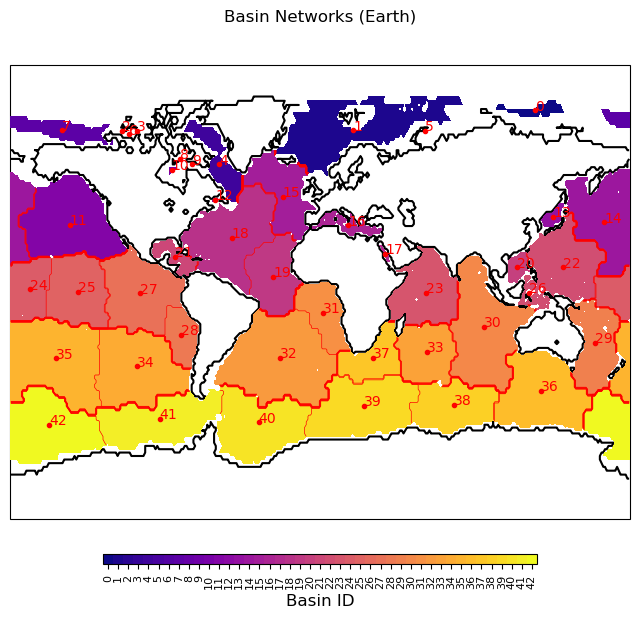

In [1]:
# Import necessary libraries
import ExoCcycle as EC
import os
import matplotlib as mpl
import numpy as np


# Initial basin definition class
body = ["Earth", "Mars", "Venus", "Moon"]
body = body[0]
basins = EC.utils.Basins(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                         filename="{}_resampled_1deg.nc".format(body),
                         body=body);

# Define directory to netCDF4 to be used for community detection
communityParm = '/home/bogumil/Documents/data/oceanParameter/Benedetti_etal_2021/Plankton_Species_data_0.00Ma.nc'
#communityParm = '/home/bogumil/Documents/data/oceanParameter/Benedetti_etal_2021/Phytoplankton_Species_data_0.00Ma.nc'
#communityParm = '/home/bogumil/Documents/data/oceanParameter/Benedetti_etal_2021/Zooplankton_Species_data_0.00Ma.nc'
readParm = "Band1"

#communityParm = "Bathymetry"

# Define basins based on user input boundaries

basins.defineBasinsNonUnique(minBasinCnt = 3,
                             method = "Louvain",
                             reducedRes={"on":True,"factor":1},
                             edgeParaOpt={"Parameter":communityParm, 'readParm':readParm, 'flipud':True},
                             read=False,
                             write=False,
                             verbose=False)
'''

basins.defineBasins(minBasinCnt = 3,
                    method = "Louvain",
                    reducedRes={"on":True,"factor":1},
                    read=False,
                    write=False,
                    verbose=False)

'''

# Define merger package
# The 'Lite' package applies two merger passes 1) merges basins smaller than .1%
# of total seafloor area with closest basin larger than that area, 2) same as
# 1, but with small basins defined at .5%.
basinReduction = False;
if basinReduction:
    basins.applyMergeBasinMethods(0,
                                  EC.utils.mergerPackages('Lite'),
                                  maxBasinCnt=1e10);


# Plot resulting basins with bathymetry and connections
# Note that periodic connections are not graphically shown,
# but are represented in the node network.
# Note that plotting connectors for high resolution take a very
# long time. Suggestion: set draw["connectors"] to false to speed
# up visualizeCommunities.
# Note that basin visualization might be easier for Miller
# projection with bathymetry and gridlines unplotted.
blues_cm = mpl.colormaps['Blues'].resampled(100)
basins.visualizeCommunities( cmapOpts={"cmap":blues_cm,
                                       "cbar-title":"cbar-title",
                                       "cbar-range":[np.nanmin(np.nanmin(basins.bathymetry)),
                                                     np.nanmean(basins.bathymetry)+2*np.nanstd(basins.bathymetry)]},
                             pltOpts={"valueType": "Bathymetry",
                                      "valueUnits": "m",
                                      "plotTitle":"{}".format(basins.body),
                                      "plotZeroContour":True,
                                      "nodesize":1,
                                      "connectorlinewidth":1,
                                      "projection":"Miller"},
                             draw={"nodes":False,
                                   "connectors":False,
                                   "bathymetry":False,
                                   "coastlines":True,
                                   "gridlines":False,
                                   "nodes-contour":True},
                             saveSVG=False,
                             savePNG=True)



### Plankton: Band 1 weighted - findCommunities (resolution=.5)
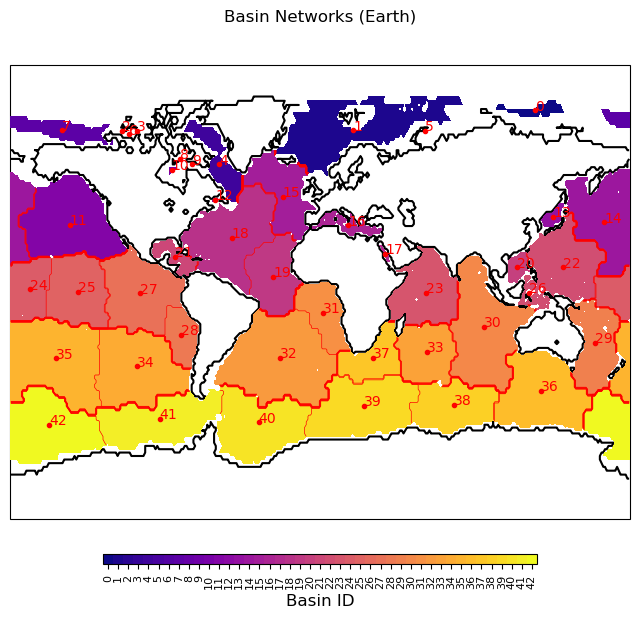

### Phytoplankton: Band 1 weighted - findCommunities (resolution=.5)
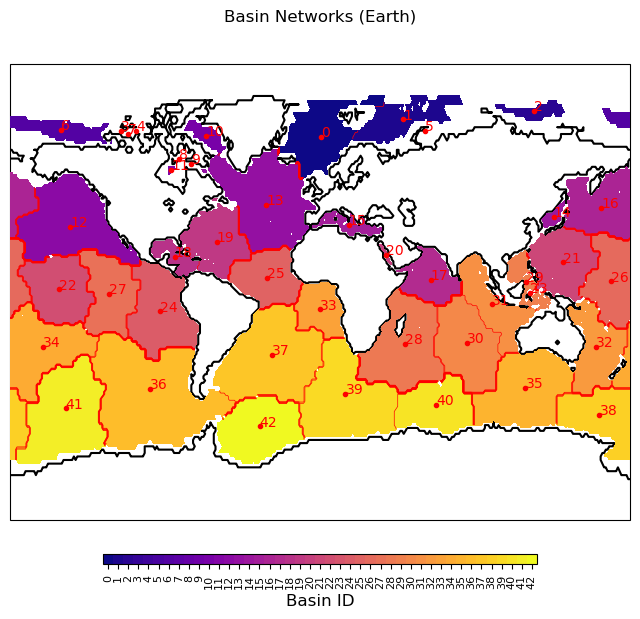

### Zooplankton: Band 1 weighted - findCommunities (resolution=.5)
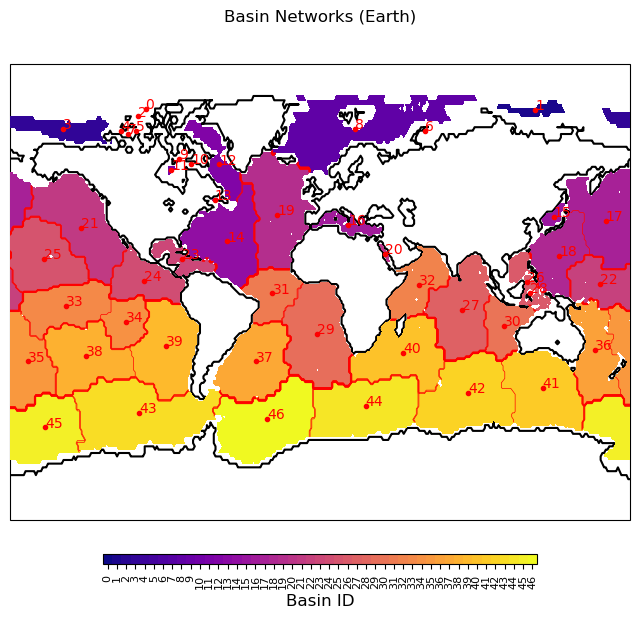



## Plankton

### Band 1 weighted (no node spacing normalization) - findCommunities (resolution=.5)
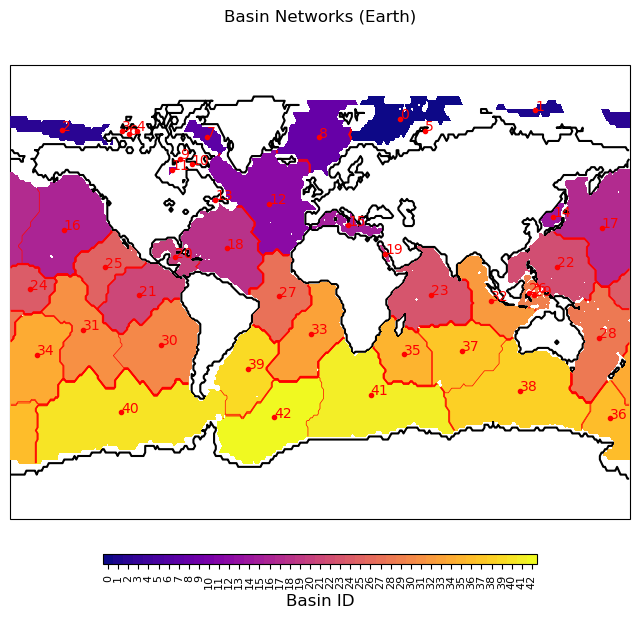

### Band 1 weighted - findCommunities (resolution=.5)
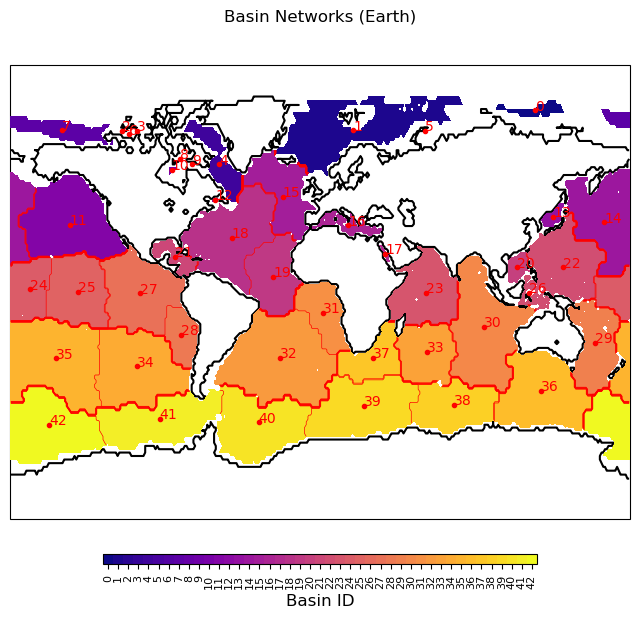

### Band 1 weighted (no node spacing normalization) - findCommunities (resolution=.1)
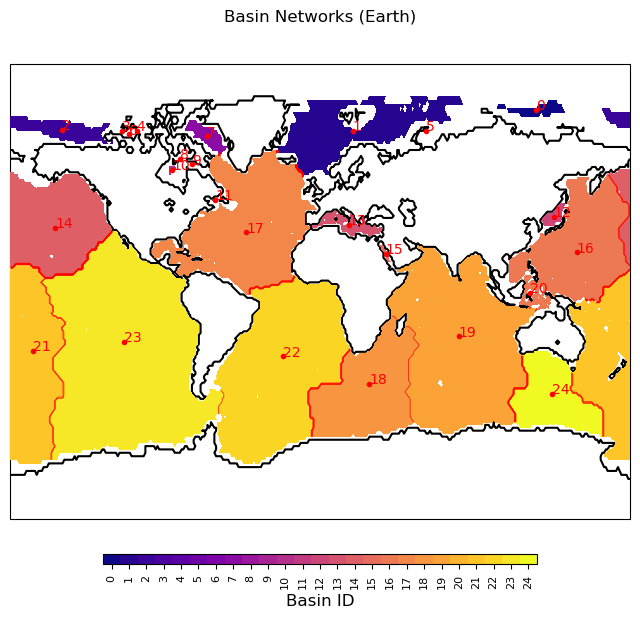

### Band 1 weighted - findCommunities (resolution=.1)
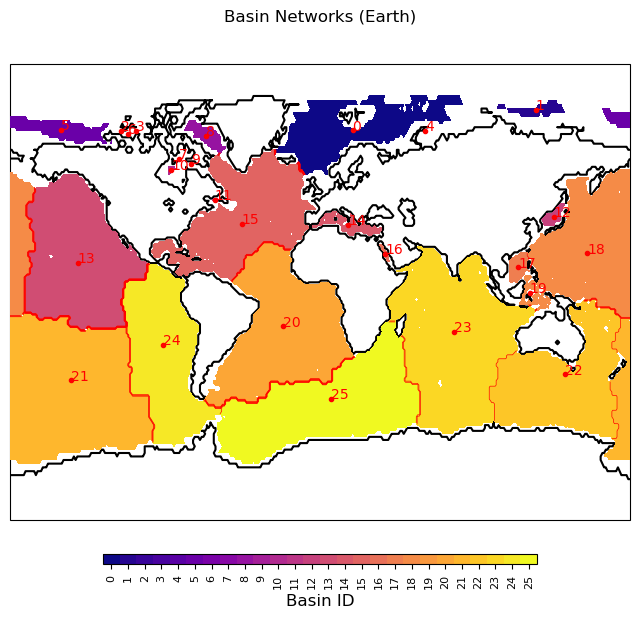

### nodeSpace weighted (Shows the effect of continents) - findCommunities (resolution=.1)
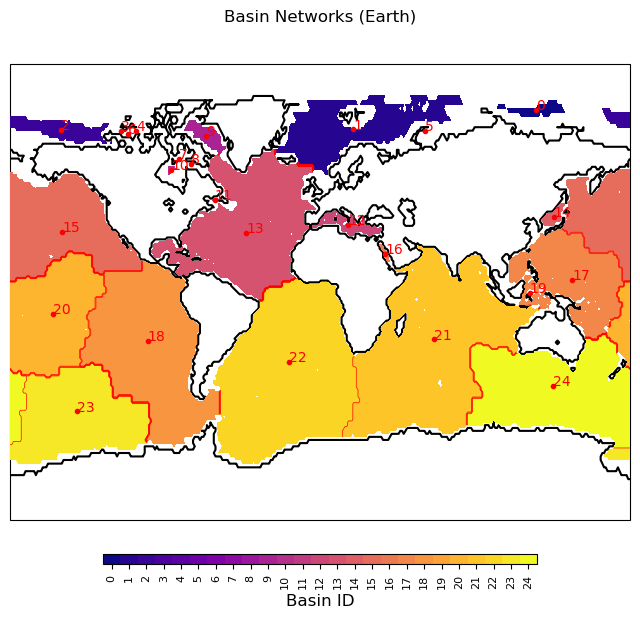


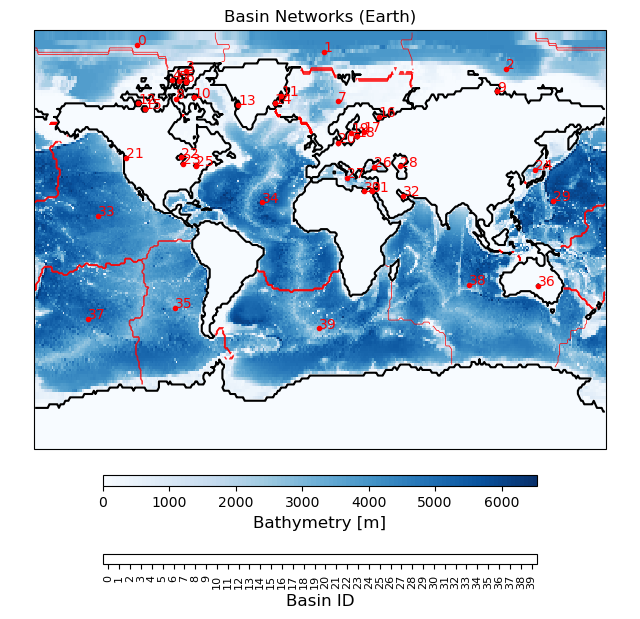

In [4]:

blues_cm = mpl.colormaps['Blues'].resampled(100)
basins.visualizeCommunities( cmapOpts={"cmap":blues_cm,
                                       "cbar-title":"cbar-title",
                                       "cbar-range":[np.nanmin(np.nanmin(basins.bathymetry)),
                                                     np.nanmean(basins.bathymetry)+2*np.nanstd(basins.bathymetry)]},
                             pltOpts={"valueType": "Bathymetry",
                                      "valueUnits": "m",
                                      "plotTitle":"{}".format(basins.body),
                                      "plotZeroContour":True,
                                      "nodesize":1,
                                      "connectorlinewidth":1,
                                      "projection":"Miller"},
                             draw={"nodes":False,
                                   "connectors":False,
                                   "bathymetry":True,
                                   "coastlines":True,
                                   "gridlines":False,
                                   "nodes-contour":True},
                             saveSVG=False,
                             savePNG=True)




## <center>Read network, merge basins, and plot merged basins: 5</center>

Notes :
1. A seed is used for the Louvain algorithm and we read in the network created above, so we can merge the same basin IDs as above to recreate the same 3 basin system.
2. The network is not save with updated basin IDs.


In [ ]:
# Import necessary libraries
import ExoCcycle as EC
import os
import matplotlib as mpl
import numpy as np


# Initial basin definition class
body = ["Earth", "Mars", "Venus", "Moon"]
body = body[0]
basins = EC.utils.Basins(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                         filename="{}_resampled_1deg.nc".format(body),
                         body=body);

# Define basins based on user input boundaries
basins.defineBasins(minBasinCnt = 3,
                    method = "Louvain",
                    reducedRes={"on":True,"factor":1},
                    read=True,
                    write=False,
                    verbose=False)


# Merge basins north of Atlantic
basins.mergeBasins(0,[1,2,3,4,5,6,8,9,11,12,13,14,15,16,17], write=False)

# Merge basins north of Atlantic with Atlantic.
# Note the new basinIDs
basins.mergeBasins(0,[1,2,3,5,7,8,9,10,11,12,13,14,19], write=False)

# Merge basins for Pacific ocean.
# Note the new basinIDs
basins.mergeBasins(1,[2,4,5,9,10], write=False)

# Merge basins for Indian ocean.
# Note the new basinIDs
basins.mergeBasins(2,[3,4,5,6], write=False)

# Plot resulting basins with bathymetry and connections
# Note that periodic connections are not graphically shown,
# but are represented in the node network.
# Note that plotting connectors for high resolution take a very
# long time. Suggestion: set draw["connectors"] to false to speed
# up visualizeCommunities.
# Note that basin visualization might be easier for Miller
# projection with bathymetry and gridlines unplotted.
blues_cm = mpl.colormaps['Blues'].resampled(100)
basins.visualizeCommunities( cmapOpts={"cmap":blues_cm,
                                       "cbar-title":"cbar-title",
                                       "cbar-range":[np.nanmin(np.nanmin(basins.bathymetry)),
                                                     np.nanmean(basins.bathymetry)+2*np.nanstd(basins.bathymetry)]},
                             pltOpts={"valueType": "Bathymetry",
                                      "valueUnits": "m",
                                      "plotTitle":"{}".format(basins.body),
                                      "plotZeroContour":True,
                                      "nodesize":1,
                                      "connectorlinewidth":1,
                                      "projection":"Mollweide"},
                             draw={"nodes":True,
                                   "connectors":False,
                                   "bathymetry":True,
                                   "coastlines":True,
                                   "gridlines":False,
                                   "nodes-contour":False},
                             saveSVG=False,
                             savePNG=False)


## <center>Calculate Basin Parameters and Basin Connectivity Parameters and Save them to a new NetCDF4 file: 6-11</center>


Notes:

1. If uses run the the saveCcycleParameter method without previously calculating basin connectivity parameters with the calculateBasinConnectivityParameters method, then connectivity parameters will not be saved to the new netCDF4 file. 

In [ ]:
# Calculate basin bathymetry parameters
basins.calculateBasinParameters(verbose=True)

# Calculate basin connectivity parameters
basins.calculateBasinConnectivityParameters(verbose=True)

# Expand original bathymetry netCDF4 file by writting a new basin bathymetry
# netCDF4 file that also contains basin bathymetry parameters.
basins.saveCcycleParameter(verbose=True);


## <center>Other plotting Choices: 12</center>

In [ ]:
# Import necessary libraries
import ExoCcycle as EC
import os
import matplotlib as mpl
import numpy as np


# Initial basin definition class
body = ["Earth", "Mars", "Venus", "Moon"]
body = body[0]
basins = EC.utils.Basins(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                         filename="{}_resampled_1deg.nc".format(body),
                         body=body);

# Define basins based on user input boundaries
basins.defineBasins(minBasinCnt = 3,
                    method = "Louvain",
                    reducedRes={"on":True,"factor":1},
                    read=True,
                    write=False,
                    verbose=False)


# Plot resulting basins with bathymetry and connections
# Note that periodic connections are not graphically shown,
# but are represented in the node network.
# Note that plotting connectors for high resolution take a very
# long time. Suggestion: set draw["connectors"] to false to speed
# up visualizeCommunities.
# Note that basin visualization might be easier for Miller
# projection with bathymetry and gridlines unplotted.
blues_cm = mpl.colormaps['Blues'].resampled(100)
basins.visualizeCommunities( cmapOpts={"cmap":blues_cm,
                                       "cbar-title":"cbar-title",
                                       "cbar-range":[np.nanmin(np.nanmin(basins.bathymetry)),
                                                     np.nanmean(basins.bathymetry)+2*np.nanstd(basins.bathymetry)]},
                             pltOpts={"valueType": "Bathymetry",
                                      "valueUnits": "m",
                                      "plotTitle":"{}".format(basins.body),
                                      "plotZeroContour":True,
                                      "nodesize":1,
                                      "connectorlinewidth":1,
                                      "projection":"Robinson"},
                             draw={"nodes":False,
                                   "connectors":False,
                                   "bathymetry":True,
                                   "coastlines":True,
                                   "gridlines":False,
                                   "nodes-contour":True},
                             saveSVG=False,
                             savePNG=True)


